# Introduction

This demo is for repairing a neural network that repairs the affine transform neural network example to follow a certain constraint. We perform the folowing operations here:

1. Load the neural network and samples that have both normal and adverserial examples.
2. Define the constraints
3. Define the layer to repair and run the repair

In [1]:
import os
import argparse
from csv import writer
from datetime import datetime
import numpy as np
from affine_utils import (
    plot_dataset,
    model_eval,
    original_data_loader,
    give_polys,
    give_constraints,
)
from shapely.affinity import scale
from nnreplayer.utils.options import Options
from nnreplayer.utils.utils import constraints_class
from nnreplayer.repair.repair_weights_class import NNRepair
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F

## Initialize Directories to Read/Store Variables

In [2]:
def check_log_directories(path_read, path_write, layer_to_repair):
    """_summary_

    Args:
        path_read (_type_): _description_
        path_write (_type_): _description_

    Raises:
        ImportError: _description_
    """
    if not os.path.exists(path_read + "/model"):
        raise ImportError(f"path {path_read}/model does not exist!")

    if not os.path.exists(path_write):
        os.makedirs(path_write)
        print(f"Directory: {path_write} is created!")

    if not os.path.exists(path_write + "/logs"):
        os.makedirs(path_write + "/logs")

    if not os.path.exists(path_write + "/summery"):
        os.makedirs(path_write + "/summery")

    if not os.path.exists(path_write):
        os.makedirs(path_write + f"/model_layer_{layer_to_repair}")

    if not os.path.exists(path_write + "/stats"):
        os.makedirs(path_write + "/stats")

In [3]:
direc = os.getcwd()
path_read = os.path.join(direc, "original_net")
path_write = os.path.join(direc, "repair_net")



In [4]:
if not os.path.exists(path_read + "/data/input_output_data_tc1.pickle"):
    raise ImportError(
        "path {path_read}/data/input_output_data_tc1.pickle does not exist!"
    )
with open(path_read + "/data/input_output_data_tc1.pickle", "rb") as data:
    dataset = pickle.load(data)
    
x_train, y_train, x_test, y_test = dataset[0], dataset[1], dataset[2], dataset[3]

## Define the Constraints

In [5]:
poly_orig, poly_trans, poly_const = give_polys()
A, b = give_constraints(
    scale(poly_const, xfact=0.98, yfact=0.98, origin="center")
)

# input the constraint list
constraint_inside = constraints_class("inside", A, b)
output_constraint_list = [constraint_inside]
output_constraint_list

[constraints_class(constraint_type='inside', A=array([[-0.70710678, -0.70710678],
        [ 0.70710678, -0.70710678],
        [-0.70710678,  0.70710678],
        [ 0.70710678,  0.70710678]]), B=array([[-2.31053391],
        [ 1.225     ],
        [ 1.225     ],
        [ 4.76053391]]))]

## Repairing Layer 3

Define the Layer to Repair

In [6]:
layer_to_repair = 3

check_log_directories(path_read, path_write, layer_to_repair)



Load the Neural Network

In [7]:
# load model
model_path = os.path.join(path_read, "model", "affine_transform_pt_orig_model.pt")
model_orig = torch.torch.jit.load(model_path)
model_orig.eval()

RecursiveScriptModule(
  original_name=Net
  (fc1): RecursiveScriptModule(original_name=Linear)
  (fc2): RecursiveScriptModule(original_name=Linear)
  (fc3): RecursiveScriptModule(original_name=Linear)
)

Define Optimizer Options

In [8]:
max_weight_bound = 5
cost_weights = np.array([1.0, 1.0])
options = Options(
    "gdp.bigm",
    "gurobi",
    "python",
    "keras",
    {
        "timelimit": 3600,
        "mipgap": 0.001,
        "mipfocus": 2,
        "improvestarttime": 3300,
        "logfile": path_write
        + f"/logs/opt_log_layer{layer_to_repair}.log",
    },
)


Start Repair

In [9]:
repair_obj = NNRepair(model_orig, "pytorch")

# print(f)
repair_obj.compile(
    x_train,
    y_train,
    layer_to_repair,
    output_constraint_list=output_constraint_list,
    cost_weights=cost_weights,
    max_weight_bound=max_weight_bound,
)
out_model = repair_obj.repair(options)


Activating Last layer
Set parameter TimeLimit to value 3600
Set parameter MIPGap to value 0.001
Set parameter MIPFocus to value 2
Set parameter ImproveStartTime to value 3300
Set parameter LogFile to value "/home/local/ASUAD/tkhandai/nn_repair/NNRepLayer_v2/demos/Affine Transform Demo Pytorch/repair_net/logs/opt_log_layer3.log"
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads
Optimize a model with 1494 rows, 643 columns and 2988 nonzeros
Model fingerprint: 0x2c1af10f
Model has 631 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-01, 1e+00]
  Objective range  [4e-03, 4e-02]
  QObjective range [1e-02, 2e+00]
  Bounds range     [5e+00, 1e+01]
  RHS range        [1e-01, 5e+00]
Presolve removed 441 rows and 12 columns
Presolve time: 0.01s
Presolved: 1053 rows, 1051 columns, 2526 nonzeros
Presolved model has 631 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 De

In [10]:
print(path_write)

/home/local/ASUAD/tkhandai/nn_repair/NNRepLayer_v2/demos/Affine Transform Demo Pytorch/repair_net


In [11]:
repair_obj.summary(direc=path_write + "/summery")

In [12]:
model_scripted = torch.jit.script(out_model) # Export to TorchScript
print(os.path.join(path_write, f"model_layer_{layer_to_repair}.pth"))
model_scripted.save(os.path.join(path_write, f"model_layer_{layer_to_repair}.pth"))



/home/local/ASUAD/tkhandai/nn_repair/NNRepLayer_v2/demos/Affine Transform Demo Pytorch/repair_net/model_layer_3.pth


In [13]:
# with open(
#     path_write
#     + f"/stats/repair_layer{layer_to_repair}_accs_stats_tc1.csv",
#     "a+",
#     newline="",
# ) as write_obj:
#     # Create a writer object from csv module
#     csv_writer = writer(write_obj)
#     model_evaluation = model_eval(
#         out_model,
#         keras.models.load_model(path_read + "/model"),
#         path_read,
#         poly_const,
#     )
#     for key, item in options.optimizer_options.items():
#         model_evaluation.append(key)
#         model_evaluation.append(item)
#     model_evaluation.append("max_weight_bound")
#     model_evaluation.append(max_weight_bound)
#     model_evaluation.append("cost weights")
#     model_evaluation.append(cost_weights)
#     model_evaluation.append(str(datetime.now()))
#     # Add contents of list as last row in the csv file
#     csv_writer.writerow(model_evaluation)

In [14]:
def pt_get_weights(mlp):
    """_summary_

    Args:
        mlp (_type_): _description_

    Returns:
        _type_: _description_
    """
    params = []
    for param_tensor in mlp.state_dict():
        param = mlp.state_dict()[param_tensor].numpy()
        if "weight" in param_tensor.split("."):
            params.append(param.T)
        else:
            params.append(param)
    
    return params

In [15]:
x_train_tensor = torch.Tensor(x_train)
with torch.no_grad():
    y_predict_tensor = out_model(x_train_tensor)
y_predict_train = y_predict_tensor.numpy()


x_test_tensor = torch.Tensor(x_test)
with torch.no_grad():
    y_predict_tensor = out_model(x_test_tensor)
y_predict_test = y_predict_tensor.numpy()


----------------------
Data samples Visualization (training)


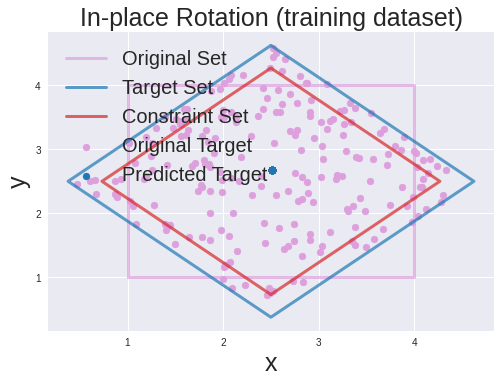

----------------------
Data samples Visualization (testing)


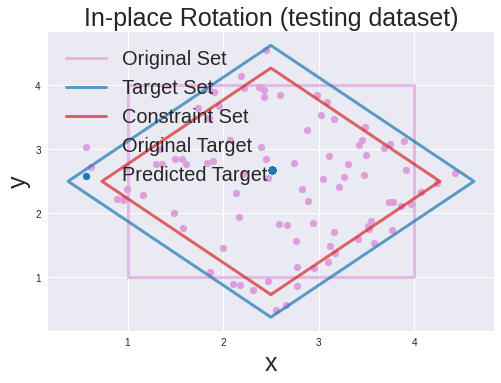

In [16]:
plot_dataset(
    [poly_orig, poly_trans, poly_const],
    [y_train, y_predict_train],
    label="training",
)
plot_dataset(
    [poly_orig, poly_trans, poly_const],
    [y_test, y_predict_test],
    label="testing",
)